# Uber ride fare prediction

**Problem description**

This project focuses on analyzing Uber ride fares, including exploratory data analysis (EDA) with hypothesis testing, and building a model to predict future ride costs. The data is sourced from Kaggle: [Uber Fares Dataset](https://www.kaggle.com/datasets/yasserh/uber-fares-dataset/data).

**Project objective:**
- Understand the structure of the data and key factors affecting fares.
- Build a predictive model that estimates future ride costs based on features like location, distance, and ride time.

**Significance of the project:**
Predicting ride costs can be beneficial for Uber customers who want to better plan their expenses and for operators to optimize services and implement dynamic pricing effectively.

**The dataset includes the following columns:**
- `key` – a unique identifier for each trip.
- `fare_amount` – the cost of each trip in USD (target variable).
- `pickup_datetime` – the date and time when the meter was engaged.
- `passenger_count` – the number of passengers in the vehicle (entered by the driver).
- `pickup_longitude` – the longitude where the meter was engaged.
- `pickup_latitude` – the latitude where the meter was engaged.
- `dropoff_longitude` – the longitude where the meter was disengaged.
- `dropoff_latitude` – the latitude where the meter was disengaged.

---

## Action Plan

1. Exploratory Data Analysis (EDA)
2. Data Preprocessing
3. Model Development and Evaluation


## 1. Import Libraries

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
from scipy.stats import kstest, zscore, kruskal
import calendar
from sklearn.model_selection import train_test_split


## 2. Download the Dataset

In [2]:
dataset_url = 'https://www.kaggle.com/datasets/yasserh/uber-fares-dataset/data'

In [3]:
od.download(dataset_url)

Skipping, found downloaded files in ".\uber-fares-dataset" (use force=True to force download)


In [4]:
data_dir = './uber-fares-dataset'

### Loading Training Set

- Ignore the `key` column
- Parse pickup datetime while loading data 

In [89]:
selected_cols = 'fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count'.split(',')

df = pd.read_csv(data_dir+'/uber.csv',
                 usecols=selected_cols, 
                 parse_dates=["pickup_datetime"])

In [6]:
df.duplicated().sum()

np.int64(0)

In [61]:
df.shape

(200000, 7)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        200000 non-null  float64            
 1   pickup_datetime    200000 non-null  datetime64[ns, UTC]
 2   pickup_longitude   200000 non-null  float64            
 3   pickup_latitude    200000 non-null  float64            
 4   dropoff_longitude  199999 non-null  float64            
 5   dropoff_latitude   199999 non-null  float64            
 6   passenger_count    200000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 10.7 MB


In [9]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [10]:
df.pickup_datetime.min(), df.pickup_datetime.max()

(Timestamp('2009-01-01 01:15:22+0000', tz='UTC'),
 Timestamp('2015-06-30 23:40:39+0000', tz='UTC'))

- **Data size:** The dataset contains 200,000 rows and 7 columns.  
- **Data anomalies:**  
  - `fare_amount`: Minimum value is -52 (illogical), maximum is 499 (potential outlier).  
  - `passenger_count`: Minimum is 0, maximum is 208, which requires verification.  
  - Geographic coordinates contain values outside realistic ranges.  
- **Pickup dates:** The pickup dates range from January 1st, 2009, to June 30th, 2015.


## 3. Exploratory Data Analysis and Visualization

In [11]:
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1
199996,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1
199997,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2
199998,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1


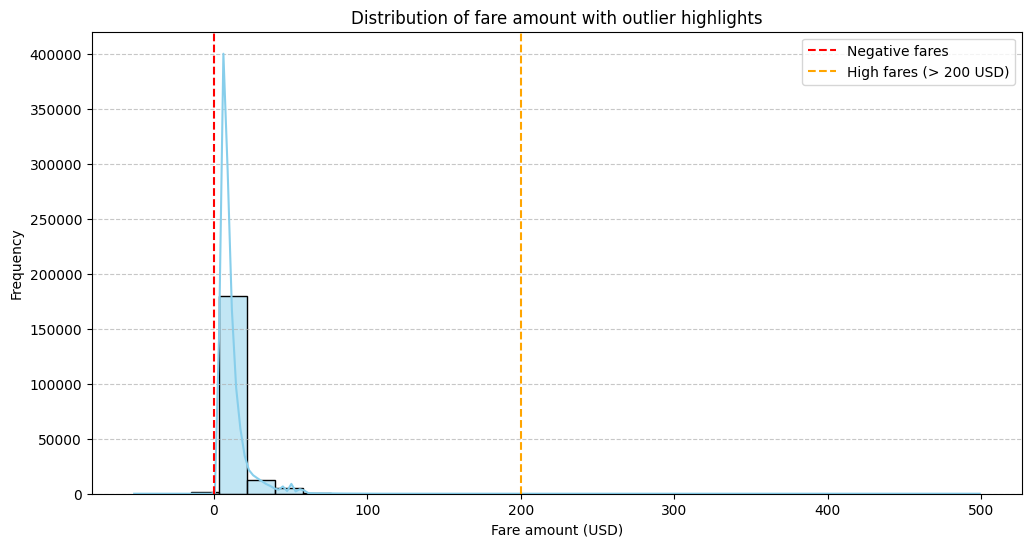

In [12]:
plt.figure(figsize=(12, 6))
sns.histplot(df['fare_amount'], bins=30, kde=True, color='skyblue', edgecolor='black')

plt.axvline(x=0, color='red', linestyle='--', label='Negative fares')
plt.axvline(x=200, color='orange', linestyle='--', label='High fares (> 200 USD)')

plt.title('Distribution of fare amount with outlier highlights')
plt.xlabel('Fare amount (USD)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [43]:
negative_fares = df[df['fare_amount'] < 0]
high_fares = df[df['fare_amount'] > 200]

negative_fare_count = negative_fares.shape[0]
high_fare_count = high_fares.shape[0]

print(f"The number of negative values in 'fare_amount': {negative_fare_count}")
print(f"The number of extreme high values in 'fare_amount': {high_fare_count}")


The number of negative values in 'fare_amount': 17
The number of extreme high values in 'fare_amount': 7


In [14]:
df.fare_amount.describe()

count    200000.000000
mean         11.359955
std           9.901776
min         -52.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64

### Conclusions

1. Average fare: The mean value of `fare_amount` is **11.36 USD**.  
2. Invalid values: The dataset contains 17 instances with negative values, which are logically inconsistent with the concept of fares.  
3. 75th percentile: 75% of trips cost 12.50 USD or less, indicating that the majority of fares fall within a reasonable range.  
4. Extreme values: There are 7 values exceeding 200 USD in the dataset, suggesting the presence of outliers.  
5. Distribution: The data distribution is right-skewed (mean > median), indicating that most fare amounts are relatively low, with a few extreme high values.



### Kolmogorov-Smirnov test

- Significance level (α): 0.05  
- H₀ (Null Hypothesis): The `fare_amount` data follows a normal distribution.  
- H₁ (Alternative Hypothesis): The `fare_amount` data does not follow a normal distribution.  


In [15]:
standardized_fare = zscore(df['fare_amount'])
ks_stat, ks_p_value = kstest(standardized_fare, 'norm')

print(f'KS Test Statistic: {ks_stat}')
print(f'P-value: {ks_p_value}')


KS Test Statistic: 0.20732879525075143
P-value: 0.0


**Results:**  
- KS Test Statistic: 0.2073  
- P-value: 0.0  

**Conclusion:**  
Since **p-value < 0.05**, we reject the null hypothesis (H₀) at the 5% significance level. This means the `fare_amount` data does not follow a normal distribution.

In [16]:
df.passenger_count.describe()

count    200000.000000
mean          1.684535
std           1.385997
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         208.000000
Name: passenger_count, dtype: float64

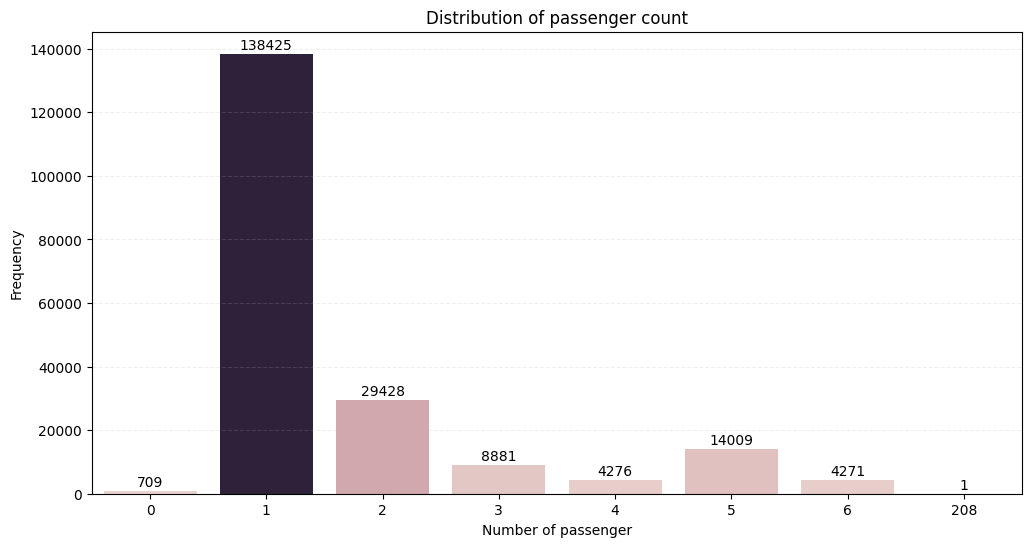

In [17]:
passenger_counts = df['passenger_count'].value_counts().sort_index()
df_passengers = df.copy()
df_passengers['passangerFreq'] = df['passenger_count'].map(df['passenger_count'].value_counts())

plt.figure(figsize=(12,6))
sns.countplot(
    x='passenger_count', 
    data=df_passengers,
    hue='passangerFreq',
    legend=False
    )

for index, value in enumerate(passenger_counts.values):
    plt.text(
        x=index, 
        y=value + 1500,
        s=str(value), 
        ha='center', 
        fontsize=10
    )

plt.title('Distribution of passenger count')
plt.xlabel('Number of passenger')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.show()

### Conclusions

1. Most trips are taken with one passenger (138,425 cases), which is the dominant value.  
2. There are atypical data points, such as 0 passengers (709 cases) and an extreme value of 208 passengers, which require cleaning.


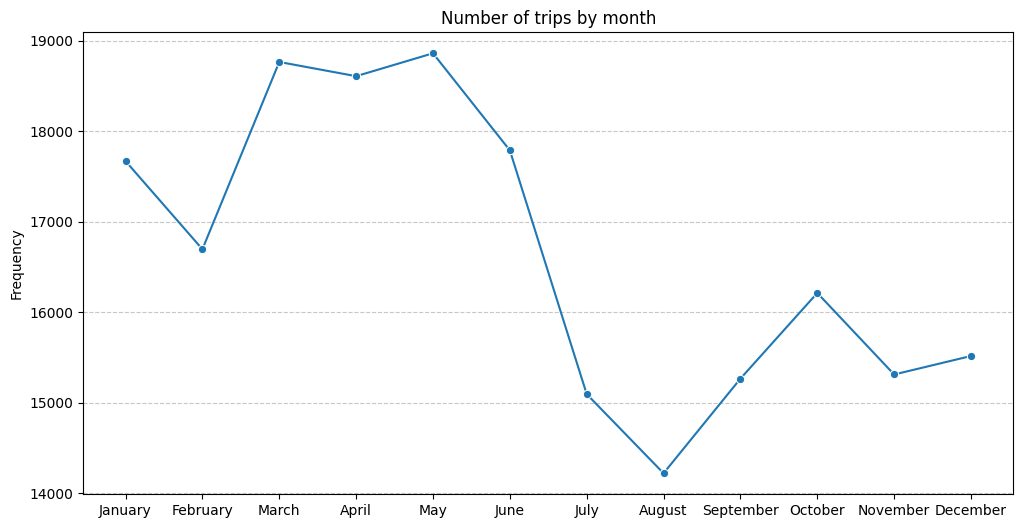

In [18]:
monthly_data = df['pickup_datetime'].dt.month.value_counts().sort_index()
month_names = [calendar.month_name[i] for i in monthly_data.index]

plt.figure(figsize=(12,6))
sns.lineplot(x=month_names, y=monthly_data.values, marker='o')
plt.title('Number of trips by month')
plt.xlabel('')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

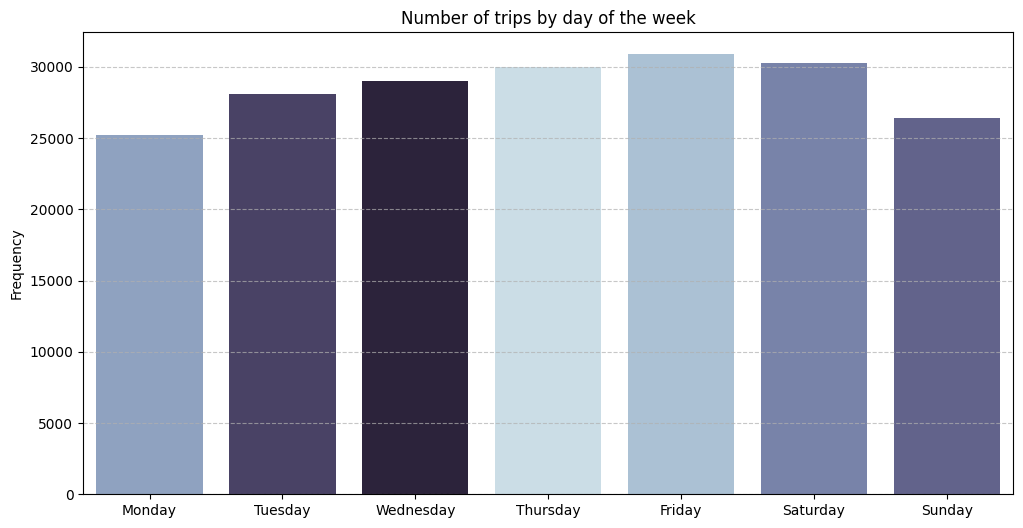

In [19]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, 
              x=df.pickup_datetime.dt.day_name(),
              order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
              hue=df.pickup_datetime.dt.day_name(),
              palette='ch:s=.25,rot=-.25',
              dodge=False
              )
plt.title('Number of trips by day of the week')
plt.xlabel('')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

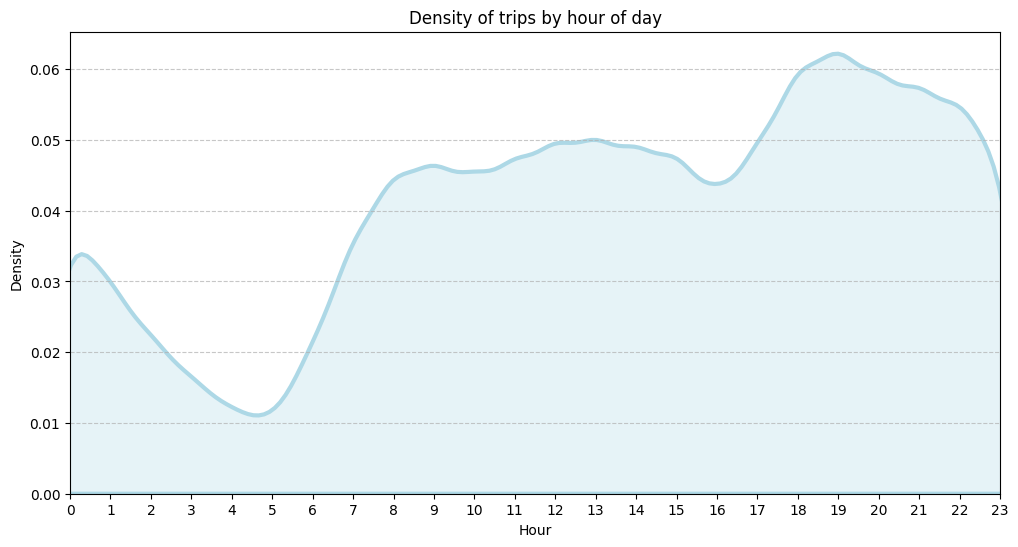

In [20]:
plt.figure(figsize=(12, 6))
sns.kdeplot(df['pickup_datetime'].dt.hour, fill=True, color='lightblue', alpha=0.3, linewidths=3)
plt.title('Density of trips by hour of day')
plt.xlabel('Hour')
plt.xlim(0, 23)
plt.xticks(range(0, 24))
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


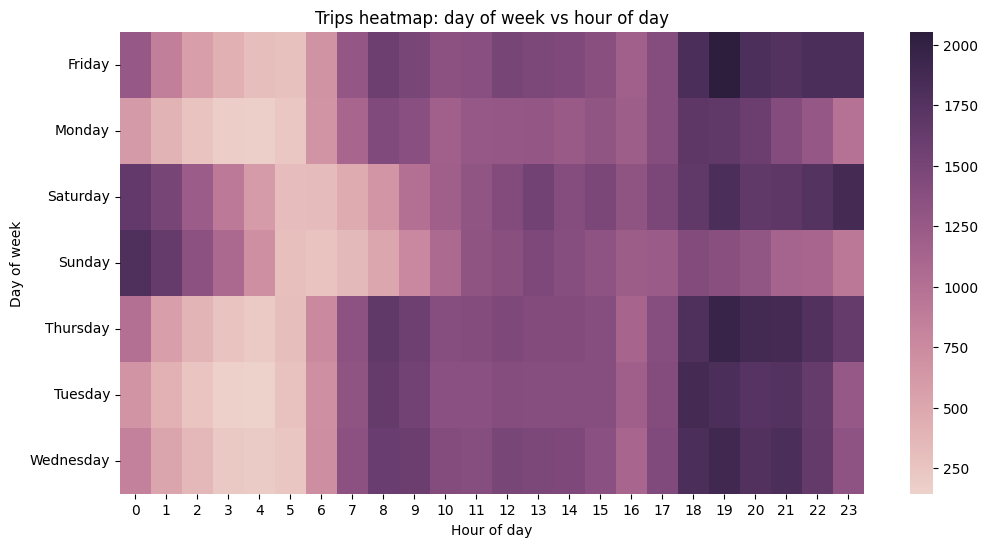

In [21]:
heatmap_data = pd.crosstab(df['pickup_datetime'].dt.day_name(), df['pickup_datetime'].dt.hour)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap=sns.cubehelix_palette(as_cmap=True), annot=False)
plt.title('Trips heatmap: day of week vs hour of day')
plt.xlabel('Hour of day')
plt.ylabel('Day of week')
plt.show()


### Conclusions

- **Seasonality:** The data shows a clear spring seasonality, with the highest number of trips in March, April, and May, and reduced activity during July and August.
- **Weekly Activity:** Higher activity is observed at the end of the week (Thursday–Saturday), with Fridays being the busiest day, while Sundays and Mondays have the lowest activity.
- **Hourly Trends:** Peak activity occurs during evening hours (6:00 PM–9:00 PM), while the fewest trips are recorded during nighttime (4:00 AM–5:00 AM).

In [22]:
invalid_coords = df[
    (df.pickup_longitude < -180) | (df.pickup_longitude > 180) |
    (df['pickup_latitude'] < -90) | (df['pickup_latitude'] > 90) |
    (df['dropoff_longitude'] < -180) | (df['dropoff_longitude'] > 180) |
    (df['dropoff_latitude'] < -90) | (df['dropoff_latitude'] > 90)
]

print(f'Number of invalid coordinates: {len(invalid_coords)}')

Number of invalid coordinates: 12


In [23]:
fare_by_weekday = df.groupby(df['pickup_datetime'].dt.day_name())['fare_amount'].mean()
fare_by_weekday = fare_by_weekday.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
fare_by_weekday


pickup_datetime
Monday       11.378528
Tuesday      11.075793
Wednesday    11.351323
Thursday     11.517768
Friday       11.439793
Saturday     11.032273
Sunday       11.756463
Name: fare_amount, dtype: float64

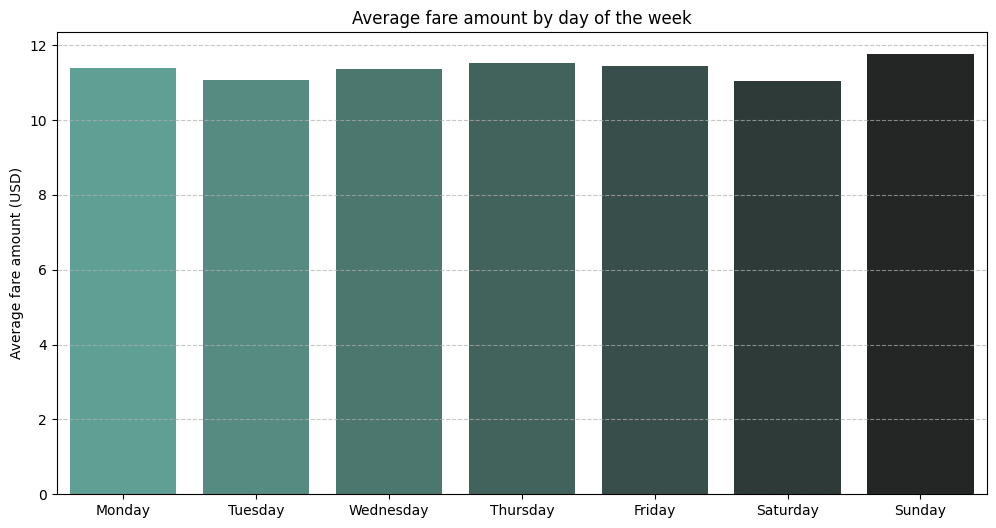

In [24]:
plt.figure(figsize=(12, 6))
sns.barplot(x=fare_by_weekday.index, y=fare_by_weekday.values, palette='dark:#5A9_r', hue=fare_by_weekday.index)
plt.title('Average fare amount by day of the week')
plt.xlabel('')
plt.ylabel('Average fare amount (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Conclusions

The average fare amount varies slightly across the days of the week, with Sunday having the highest average fare ($11.76) and Saturday the lowest ($11.03).

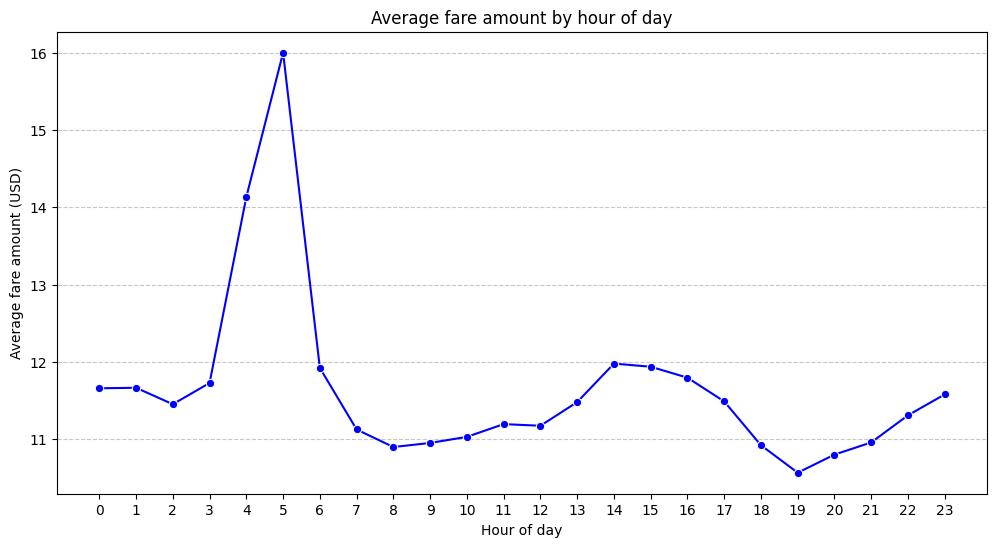

In [25]:
fare_by_hour = df.groupby(df['pickup_datetime'].dt.hour)['fare_amount'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=fare_by_hour.index, y=fare_by_hour.values, marker='o', color='blue')
plt.title('Average fare amount by hour of day')
plt.xlabel('Hour of day')
plt.ylabel('Average fare amount (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(0, 24))  
plt.show()


### Conclusions

The average fare amount peaks significantly around 4-5 AM, likely due to limited availability or longer trips, and remains relatively stable throughout the day.


### Kruskal-Wallis Test

- Significance level (α): 0.05  
- H₀ (Null Hypothesis): The average fare amount is the same across all groups of passenger count.  
- H₁ (Alternative Hypothesis): At least one group of passenger count has a different average fare amount.

In [26]:
sample_df = df.sample(400, random_state=42)
groups = [sample_df[sample_df['passenger_count'] == p]['fare_amount'] for p in range(1, 7)]

h_stat, p_value = kruskal(*groups)
print(f"Kruskal-Wallis Test: H-statistic={h_stat}, p-value={p_value}")


Kruskal-Wallis Test: H-statistic=4.109764170530943, p-value=0.5337233805951217


### Interpretation

Since the p-value > 0.05, there is no basics to reject the null hypothesis.

This indicates that there is no statistically significant difference in the average fare amount across the different groups of passenger count.

passenger_count
1    11.254158
2    11.784452
3    11.486731
4    11.642472
5    11.199698
6    12.158537
Name: fare_amount, dtype: float64


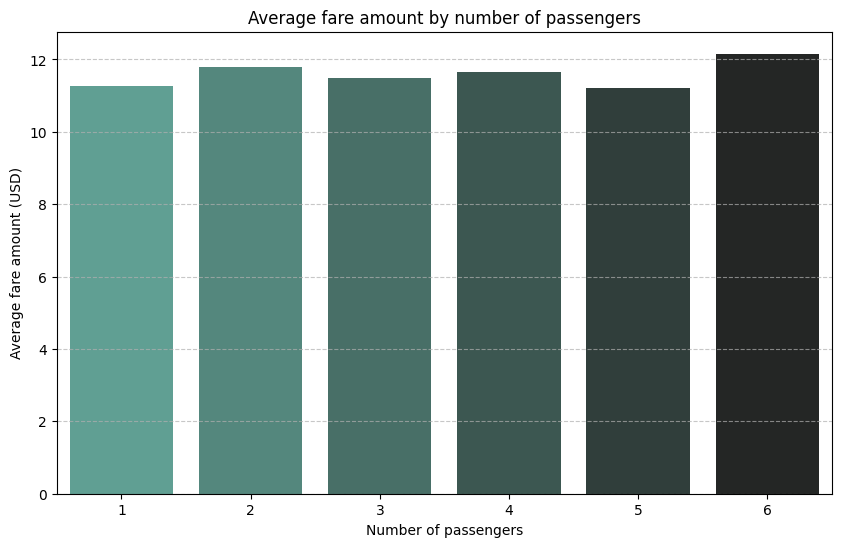

In [27]:
fare_by_passenger = df.groupby('passenger_count')['fare_amount'].mean()
fare_by_passenger = fare_by_passenger.loc[1:6,]
print(fare_by_passenger)

plt.figure(figsize=(10, 6))
sns.barplot(x=fare_by_passenger.index, y=fare_by_passenger.values, palette='dark:#5A9_r', hue=fare_by_passenger.index, legend=False)
plt.title('Average fare amount by number of passengers')
plt.xlabel('Number of passengers')
plt.ylabel('Average fare amount (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

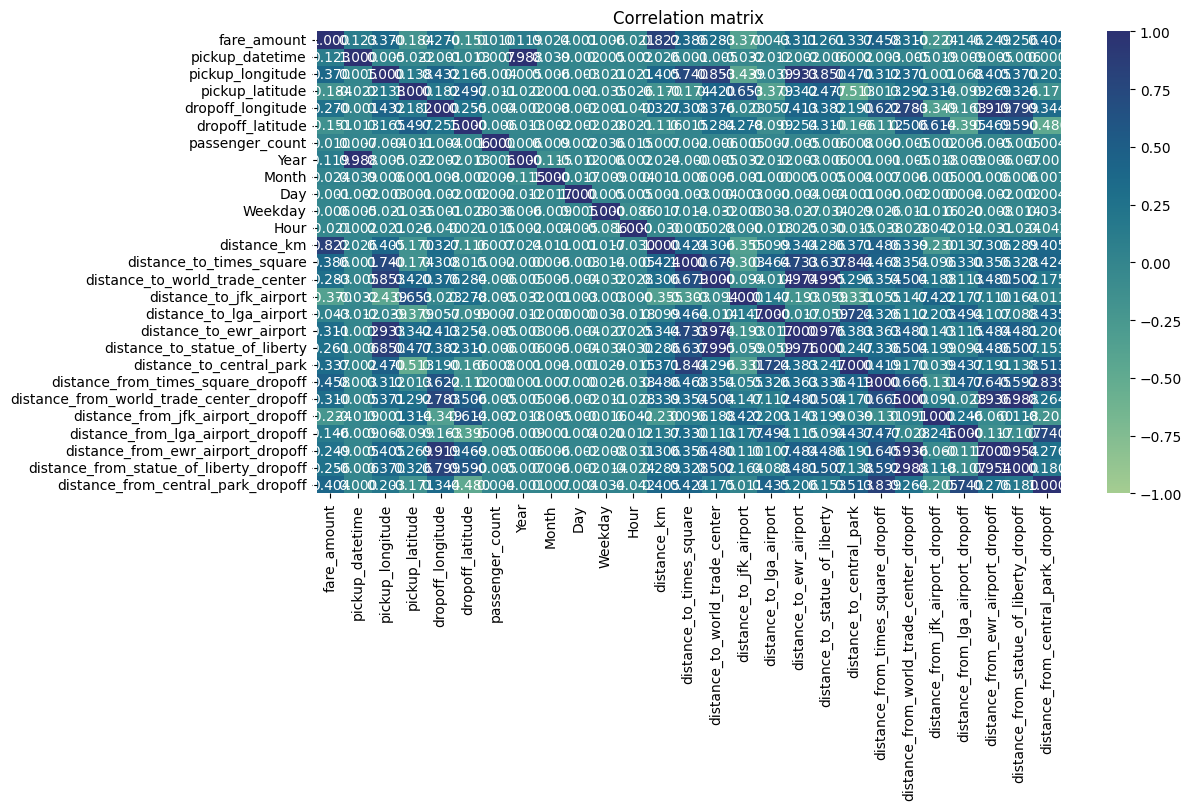

In [124]:
corrMatrix = df.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corrMatrix, annot=True, cmap="crest", fmt='.3f', vmin = -1, vmax = 1, center = 0)
plt.title('Correlation matrix')
plt.show()

## 4. Data Preprocessing

### Remove outliers and invalid data

Removing outliers ensures the dataset is clean and reliable, preventing extreme or incorrect values from skewing the analysis and model training. We will remove rows with:

- `fare_amount`: Negative values, as they are not logical.
- `passenger_count`: Values outside the valid range of 1 to 6 passengers.
- Geographic coordinates (`pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`): Invalid coordinates outside the NY.

In [90]:
print(f"Original data size: {df.shape}")

def remove_outliers(df):
    return df[
        (df['fare_amount'] >= 1.0) & 
        (df['passenger_count'].between(1, 6)) &
        (df['pickup_longitude'].between(-75, -72)) &
        (df['pickup_latitude'].between(40, 42)) &
        (df['dropoff_longitude'].between(-75, -72)) &
        (df['dropoff_latitude'].between(40, 42))
    ]

df = remove_outliers(df)

print(f"Data size after outlier removal: {df.shape}")


Original data size: (200000, 7)
Data size after outlier removal: (195097, 7)


### Impute missing numerical data

After analyzing the dataset, no missing values were detected in any of the columns.

In [91]:
df.isna().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

### Feature engineering

Feature engineering allows us to extract additional meaningful information from the existing dataset, which can improve the accuracy and interpretability of predictive models.

Planned Operations:
- Extract parts of date: add columns for year, month, day, day of the week, and hour from the `pickup_datetime` column.
- Add distance between pickup and drop: calculate the distance in kilometers between the pickup and drop-off locations using the Haversine formula.
- Add Distance from popular landmarks: calculate the distance from pickup and drop-off points to popular landmarks, such as. These landmarks are based on the list from [Tourism in New York City](https://en.wikipedia.org/wiki/Tourism_in_New_York_City):
  - Times Square
  - World Trade Center
  - Central Park
  - Statue of Liberty
  - JFK Airport
  - LGA Airport
  - EWR Airport

In [93]:
def add_dateparts(df, col):
    df['Year'] = df[col].dt.year
    df['Month'] = df[col].dt.month
    df['Day'] = df[col].dt.day
    df['Weekday'] = df[col].dt.weekday
    df['Hour'] = df[col].dt.hour

add_dateparts(df, 'pickup_datetime')
    

In [95]:
def haversine_np(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km


def add_trip_distance(df):
    df['distance_km'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])

add_trip_distance(df)

In [107]:
landmarks = {
    "Times Square": (-73.9855, 40.7580),
    "World Trade Center": (-74.0131, 40.7115),
    "JFK Airport": (-73.7781, 40.6413),
    "LGA Airport": (-73.8740, 40.7769),
    "EWR Airport": (-74.1745, 40.6895),
    "Statue of Liberty": (-74.0445, 40.6892),
    "Central Park": (-73.9683, 40.7851)
}

def add_landmark_distances(df, landmarks):
    for name, (lon, lat) in landmarks.items():
        df[f"distance_to_{name.replace(' ', '_').lower()}"] = haversine_np(
            df['pickup_longitude'], df['pickup_latitude'], lon, lat
        )

add_landmark_distances(df, landmarks)


In [108]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Day,...,distance_to_ewr_airport,distance_to_statue_of_liberty,distance_to_central_park,distance_from_times_square_dropoff,distance_from_world_trade_center_dropoff,distance_from_jfk_airport_dropoff,distance_from_lga_airport_dropoff,distance_from_ewr_airport_dropoff,distance_from_statue_of_liberty_dropoff,distance_from_central_park_dropoff
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,...,15.683180,6.633326,5.832831,4.041292,1.733548,20.760567,12.133862,15.209684,5.352769,7.361580
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,...,15.773168,6.053859,6.689963,1.152601,4.583937,21.905418,10.580322,16.582461,7.982693,4.458014
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,...,15.368224,6.624671,5.816470,2.524956,8.017147,21.319149,7.467991,20.096702,11.558310,1.465574
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,...,20.144671,12.677749,0.916934,5.317916,10.970671,23.934975,8.225767,21.684251,14.329900,2.043401
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,...,21.870565,11.767161,5.834464,1.105778,6.474137,21.154065,8.518264,18.742863,10.013704,2.681042


## Training, validation and test sets


In [112]:
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

In [113]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (117057, 27)
val_df.shape : (39020, 27)
test_df.shape : (39020, 27)


## Identifying input and target columns.

In [118]:
input_cols = [col for col in df.columns if col not in ['fare_amount', 'pickup_datetime']]
target_col = 'fare_amount'

In [119]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [120]:
train_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Day,Weekday,Hour,...,distance_to_ewr_airport,distance_to_statue_of_liberty,distance_to_central_park,distance_from_times_square_dropoff,distance_from_world_trade_center_dropoff,distance_from_jfk_airport_dropoff,distance_from_lga_airport_dropoff,distance_from_ewr_airport_dropoff,distance_from_statue_of_liberty_dropoff,distance_from_central_park_dropoff
167725,-73.978657,40.756217,-73.982102,40.752237,3,2013,9,1,6,21,...,18.083346,9.285013,3.325874,0.701390,5.225546,21.151551,9.502333,17.640129,8.757148,3.832192
89538,-73.862652,40.769010,-73.987463,40.732503,1,2010,4,30,4,13,...,27.707467,17.696417,9.068321,2.838173,3.179510,20.345785,10.750119,16.463631,6.799900,6.063337
139145,-73.991367,40.750028,-73.974102,40.760328,4,2009,7,23,3,16,...,16.826768,8.106594,4.354135,0.993669,6.342278,21.156954,8.623603,18.621870,9.880486,2.795759
24145,-74.008415,40.745135,-73.967803,40.710770,3,2010,11,17,2,17,...,15.293950,6.919052,5.578786,5.455887,3.816395,17.754038,10.787668,17.573401,6.891815,8.260036
91963,-73.956500,40.766988,-73.978757,40.765180,1,2011,6,21,1,8,...,20.277351,11.385969,2.244321,0.979148,6.629120,21.800348,8.911804,18.505509,10.096595,2.382111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55846,-73.944257,40.788072,-73.953770,40.775090,1,2013,8,26,0,6,...,22.266767,13.854860,2.049716,3.276936,8.653691,20.976663,6.715784,20.879145,12.225768,1.652941
186827,-73.982840,40.744962,-73.994233,40.746320,1,2012,12,13,3,0,...,17.279279,8.085084,4.625174,1.491681,4.182870,21.629055,10.675295,16.443595,7.629875,4.830644
124517,-73.981367,40.784438,-73.966772,40.789953,4,2010,11,9,1,6,...,19.384386,11.843371,1.101922,3.884835,9.550690,22.922001,7.939660,20.748860,12.968628,0.554402
94676,-73.984227,40.725100,-73.978428,40.724597,1,2014,3,20,3,23,...,16.509307,6.457122,6.800966,3.759366,3.262828,19.252680,10.538745,16.971105,6.815495,6.777241


In [121]:
train_targets

167725     4.00
89538     28.27
139145     7.30
24145     15.30
91963     10.10
          ...  
55846      5.00
186827     6.00
124517     5.30
94676      4.00
17854     10.50
Name: fare_amount, Length: 117057, dtype: float64

Let's also identify which of the columns are numerical and which ones are categorical.

In [126]:
train_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Day,Weekday,Hour,...,distance_to_ewr_airport,distance_to_statue_of_liberty,distance_to_central_park,distance_from_times_square_dropoff,distance_from_world_trade_center_dropoff,distance_from_jfk_airport_dropoff,distance_from_lga_airport_dropoff,distance_from_ewr_airport_dropoff,distance_from_statue_of_liberty_dropoff,distance_from_central_park_dropoff
167725,-73.978657,40.756217,-73.982102,40.752237,3,2013,9,1,6,21,...,18.083346,9.285013,3.325874,0.701390,5.225546,21.151551,9.502333,17.640129,8.757148,3.832192
89538,-73.862652,40.769010,-73.987463,40.732503,1,2010,4,30,4,13,...,27.707467,17.696417,9.068321,2.838173,3.179510,20.345785,10.750119,16.463631,6.799900,6.063337
139145,-73.991367,40.750028,-73.974102,40.760328,4,2009,7,23,3,16,...,16.826768,8.106594,4.354135,0.993669,6.342278,21.156954,8.623603,18.621870,9.880486,2.795759
24145,-74.008415,40.745135,-73.967803,40.710770,3,2010,11,17,2,17,...,15.293950,6.919052,5.578786,5.455887,3.816395,17.754038,10.787668,17.573401,6.891815,8.260036
91963,-73.956500,40.766988,-73.978757,40.765180,1,2011,6,21,1,8,...,20.277351,11.385969,2.244321,0.979148,6.629120,21.800348,8.911804,18.505509,10.096595,2.382111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55846,-73.944257,40.788072,-73.953770,40.775090,1,2013,8,26,0,6,...,22.266767,13.854860,2.049716,3.276936,8.653691,20.976663,6.715784,20.879145,12.225768,1.652941
186827,-73.982840,40.744962,-73.994233,40.746320,1,2012,12,13,3,0,...,17.279279,8.085084,4.625174,1.491681,4.182870,21.629055,10.675295,16.443595,7.629875,4.830644
124517,-73.981367,40.784438,-73.966772,40.789953,4,2010,11,9,1,6,...,19.384386,11.843371,1.101922,3.884835,9.550690,22.922001,7.939660,20.748860,12.968628,0.554402
94676,-73.984227,40.725100,-73.978428,40.724597,1,2014,3,20,3,23,...,16.509307,6.457122,6.800966,3.759366,3.262828,19.252680,10.538745,16.971105,6.815495,6.777241
